https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95/data_preview


In [ ]:
!python.exe -m pip install --upgrade pip

In [ ]:
!pip install plotly

#Front-end dependencies
!pip install dash

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px


In [25]:
# Do not click the links, the datasets are very very large
# About 3 minutes of runtime on desktop devices
crashes_url = 'https://data.cityofnewyork.us/api/views/h9gi-nx95/rows.csv?accessType=DOWNLOAD'
persons_url = 'https://data.cityofnewyork.us/api/views/f55k-p6yu/rows.csv?accessType=DOWNLOAD'

df_crashes = pd.read_csv(crashes_url,low_memory = False)
df_persons = pd.read_csv (persons_url,low_memory = False)

KeyboardInterrupt: 

In [ ]:
#wasnt working l7ad ma3amlt hard code imports sorry for that
df_crashes = pd.read_csv('C:\\Users\\user\\Downloads\\NYC-motor-vehicle-collisions\\data\\Motor_Vehicle_Collisions_-_Crashes.csv')
df_persons = pd.read_csv('C:\\Users\\user\\Downloads\\NYC-motor-vehicle-collisions\\data\\Motor_Vehicle_Collisions_-_Persons.csv')

C:\Users\user\AppData\Local\Temp\ipykernel_9764\1264906091.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_crashes = pd.read_csv('C:\\Users\\user\\Downloads\\NYC-motor-vehicle-collisions\\data\\Motor_Vehicle_Collisions_-_Crashes.csv')
C:\Users\user\AppData\Local\Temp\ipykernel_9764\1264906091.py:2: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_persons = pd.read_csv('C:\\Users\\user\\Downloads\\NYC-motor-vehicle-collisions\\data\\Motor_Vehicle_Collisions_-_Persons.csv')


In [ ]:
#Sarah's imports
df_crashes = pd.read_csv('D:\\NYC-motor-vehicle-collisions\\NYC-motor-vehicle-collisions\\data\Motor_Vehicle_Collisions_-_Crashes_20251108.csv')
df_persons = pd.read_csv('D:\\NYC-motor-vehicle-collisions\\NYC-motor-vehicle-collisions\\data\Motor_Vehicle_Collisions_-_Person_20251108.csv')

C:\Users\Sara\AppData\Local\Temp\ipykernel_10992\530375782.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_crashes = pd.read_csv('D:\\NYC-motor-vehicle-collisions\\NYC-motor-vehicle-collisions\\data\Motor_Vehicle_Collisions_-_Crashes_20251108.csv')
C:\Users\Sara\AppData\Local\Temp\ipykernel_10992\530375782.py:3: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_persons = pd.read_csv('D:\\NYC-motor-vehicle-collisions\\NYC-motor-vehicle-collisions\\data\Motor_Vehicle_Collisions_-_Person_20251108.csv')


============================================
Member 2 — Pre-Integration Cleaning (Steps 3–8)
============================================

In [ ]:
# ---------------------------
# Step 3: Build real datetimes + helpers
# ---------------------------

def pick_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    raise KeyError(f"None of {candidates} found in {list(df.columns)[:12]} ...")

def build_datetime(df, date_candidates, time_candidates, out_col):
    # Resolve actual names present in this DataFrame
    date_col = pick_col(df, date_candidates)
    time_col = pick_col(df, time_candidates)

    time_clean = df[time_col].astype("string").str.strip()
    date_parsed = pd.to_datetime(df[date_col], errors="coerce")

    # parse time (HH:MM, then HH:MM:SS fallback)
    time_parsed = pd.to_datetime(time_clean, format="%H:%M", errors="coerce").dt.time
    need_fallback = time_parsed.isna() & time_clean.notna()
    if need_fallback.any():
        time_parsed_fallback = pd.to_datetime(time_clean, format="%H:%M:%S", errors="coerce").dt.time
        time_parsed = time_parsed.fillna(time_parsed_fallback)

    combined = pd.to_datetime(date_parsed.dt.date.astype("string") + " " + time_clean, errors="coerce")

    df["crash_date_parsed"] = date_parsed.dt.date  # name is okay (used only for debug/peek)
    df["crash_time_parsed"] = time_parsed
    df[out_col] = combined

    # helpers required by milestone
    prefix = out_col.split("_", 1)[0]
    df[f"{prefix}_year"]  = df[out_col].dt.year
    df[f"{prefix}_month"] = df[out_col].dt.month
    df[f"{prefix}_hour"]  = df[out_col].dt.hour

    total = len(df)
    ok = df[out_col].notna().sum()
    print(f"Built {out_col}: {ok}/{total} rows parsed ({ok/total:.1%}).")
    if ok > 0:
        print("Year range:", int(df[out_col].dt.year.min()), "to", int(df[out_col].dt.year.max()))
    return df

# Apply to BOTH tables (robust to column-name variants)
df_crashes = build_datetime(
    df_crashes,
    date_candidates=["CRASH DATE", "CRASH_DATE", "crash_date"],
    time_candidates=["CRASH TIME", "CRASH_TIME", "crash_time"],
    out_col="crash_datetime"
)

df_persons = build_datetime(
    df_persons,
    date_candidates=["CRASH DATE", "CRASH_DATE", "crash_date"],
    time_candidates=["CRASH TIME", "CRASH_TIME", "crash_time"],
    out_col="person_datetime"
)


Built crash_datetime: 2218631/2218631 rows parsed (100.0%).
Year range: 2012 to 2025
Built person_datetime: 5813820/5813820 rows parsed (100.0%).
Year range: 2012 to 2025


In [ ]:
# ---------------------------
# Step 4: Coordinate sanity (flags only, do NOT drop here)
# ---------------------------

def _pick_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    raise KeyError(f"None of {candidates} found in {list(df.columns)[:12]} ...")

NYC_LAT_MIN, NYC_LAT_MAX = 40.4774, 40.9176
NYC_LON_MIN, NYC_LON_MAX = -74.2591, -73.7004

lat_col = _pick_col(df_crashes, ["LATITUDE", "latitude"])
lon_col = _pick_col(df_crashes, ["LONGITUDE", "longitude"])

df_crashes["latitude_num"]  = pd.to_numeric(df_crashes[lat_col], errors="coerce")
df_crashes["longitude_num"] = pd.to_numeric(df_crashes[lon_col], errors="coerce")

lat_missing = df_crashes["latitude_num"].isna()
lon_missing = df_crashes["longitude_num"].isna()
lat_zero    = df_crashes["latitude_num"].eq(0)
lon_zero    = df_crashes["longitude_num"].eq(0)
lat_oob     = df_crashes["latitude_num"].notna() & ~df_crashes["latitude_num"].between(NYC_LAT_MIN, NYC_LAT_MAX, inclusive="both")
lon_oob     = df_crashes["longitude_num"].notna() & ~df_crashes["longitude_num"].between(NYC_LON_MIN, NYC_LON_MAX, inclusive="both")

df_crashes["coord_issue"] = lat_missing | lon_missing | lat_zero | lon_zero | lat_oob | lon_oob

def _coord_reason(row):
    reasons = []
    if pd.isna(row["latitude_num"]):  reasons.append("lat_missing")
    if pd.isna(row["longitude_num"]): reasons.append("lon_missing")
    if pd.notna(row["latitude_num"])  and row["latitude_num"]  == 0: reasons.append("lat_zero")
    if pd.notna(row["longitude_num"]) and row["longitude_num"] == 0: reasons.append("lon_zero")
    if pd.notna(row["latitude_num"])  and (row["latitude_num"]  < NYC_LAT_MIN or row["latitude_num"]  > NYC_LAT_MAX):
        reasons.append("lat_out_of_bounds")
    if pd.notna(row["longitude_num"]) and (row["longitude_num"] < NYC_LON_MIN or row["longitude_num"] > NYC_LON_MAX):
        reasons.append("lon_out_of_bounds")
    return "|".join(reasons) if reasons else ""

df_crashes["coord_issue_reason"] = df_crashes.apply(_coord_reason, axis=1)

total = int(len(df_crashes))
bad   = int(df_crashes["coord_issue"].sum())
print(f"Coordinate sanity — good: {total-bad}/{total} ({(total-bad)/total:.1%}), issues: {bad} ({bad/total:.1%})")
display(
    df_crashes["coord_issue_reason"]
      .replace("", "ok").value_counts().head(10).to_frame("rows")
)

Coordinate sanity — good: 1971671/2218631 (88.9%), issues: 246960 (11.1%)


,rows
coord_issue_reason,
ok,1971671
lat_missing|lon_missing,240341
lat_zero|lon_zero|lat_out_of_bounds|lon_out_of_bounds,6469
lon_out_of_bounds,133
lat_out_of_bounds,11
lat_out_of_bounds|lon_out_of_bounds,6


In [ ]:
# ---------------------------
# Step 5: Make key columns consistent (IN-PLACE, keep uppercase names)
# ---------------------------

VALID_BOROUGHS = {"BROOKLYN","QUEENS","MANHATTAN","BRONX","STATEN ISLAND"}

# ZIP in crashes → exactly 5 digits (string)
if "ZIP CODE" in df_crashes.columns:
    z = df_crashes["ZIP CODE"].astype("string")
    df_crashes["ZIP CODE"] = z.str.extract(r"(\d{5})", expand=False).astype("string")

# BOROUGH in crashes: uppercase + valid set (others -> NaN)
if "BOROUGH" in df_crashes.columns:
    b = df_crashes["BOROUGH"].astype("string").str.strip().str.upper()
    b = b.replace({"STATEN IS": "STATEN ISLAND", "SI": "STATEN ISLAND"})
    df_crashes["BOROUGH"] = b.where(b.isin(VALID_BOROUGHS))

# IDs → string, keep column names uppercase
if "COLLISION_ID" in df_crashes.columns:
    df_crashes["COLLISION_ID"] = pd.to_numeric(df_crashes["COLLISION_ID"], errors="coerce").astype("Int64").astype("string")

for col in ["UNIQUE_ID", "COLLISION_ID", "PERSON_ID", "VEHICLE_ID"]:
    if col in df_persons.columns:
        df_persons[col] = pd.to_numeric(df_persons[col], errors="coerce").astype("Int64").astype("string")

# Age in persons
if "PERSON_AGE" in df_persons.columns:
    a = pd.to_numeric(df_persons["PERSON_AGE"], errors="coerce")
    df_persons["PERSON_AGE"] = a.where((a >= 0) & (a <= 120)).astype("Int64")


In [ ]:
# ---------------------------
# Step 6: Duplicates (exact, then key-based)
# ---------------------------

c_before = len(df_crashes)
df_crashes = df_crashes.drop_duplicates()
print(f"Crashes — exact dupes removed: {c_before - len(df_crashes)} (from {c_before} to {len(df_crashes)})")

p_before = len(df_persons)
df_persons = df_persons.drop_duplicates()
print(f"Persons — exact dupes removed: {p_before - len(df_persons)} (from {p_before} to {len(df_persons)})")

if "COLLISION_ID" in df_crashes.columns:
    c_before_keys = len(df_crashes)
    df_crashes = df_crashes.drop_duplicates(subset=["COLLISION_ID"], keep="first")
    print(f"Crashes — key dupes on COLLISION_ID removed: {c_before_keys - len(df_crashes)}")
    print("   COLLISION_ID unique now?", df_crashes["COLLISION_ID"].duplicated().sum() == 0)

if "UNIQUE_ID" in df_persons.columns:
    p_before_keys = len(df_persons)
    df_persons = df_persons.drop_duplicates(subset=["UNIQUE_ID"], keep="first")
    print(f"Persons — key dupes on UNIQUE_ID removed: {p_before_keys - len(df_persons)}")
    print("   UNIQUE_ID unique now?", df_persons["UNIQUE_ID"].duplicated().sum() == 0)


Crashes — exact dupes removed: 0 (from 2218631 to 2218631)
Persons — exact dupes removed: 0 (from 5813820 to 5813820)
Crashes — key dupes on COLLISION_ID removed: 0
   COLLISION_ID unique now? True
Persons — key dupes on UNIQUE_ID removed: 0
   UNIQUE_ID unique now? True


In [ ]:
# ---------------------------
# Step 7: Missing values (drop required, impute optional)
# ---------------------------

def col_exists(df, name): return name in df.columns

print("Before — rows:", len(df_crashes), "(crashes),", len(df_persons), "(persons)")

crash_required  = ["COLLISION_ID", "crash_datetime"]
person_required = ["UNIQUE_ID", "COLLISION_ID", "person_datetime"]

crash_drop_mask  = pd.Series(False, index=df_crashes.index)
for c in crash_required:
    if col_exists(df_crashes, c):
        crash_drop_mask |= df_crashes[c].isna()
crashes_to_drop  = int(crash_drop_mask.sum())

person_drop_mask = pd.Series(False, index=df_persons.index)
for c in person_required:
    if col_exists(df_persons, c):
        person_drop_mask |= df_persons[c].isna()
persons_to_drop = int(person_drop_mask.sum())

df_crashes = df_crashes.loc[~crash_drop_mask].copy()
df_persons = df_persons.loc[~person_drop_mask].copy()

print(f"Dropped (missing required) — crashes: {crashes_to_drop}, persons: {persons_to_drop}")
print("After drops — rows:", len(df_crashes), "(crashes),", len(df_persons), "(persons)")

# Impute non-critical categoricals
if col_exists(df_crashes, "BOROUGH"):
    filled = int(df_crashes["BOROUGH"].isna().sum())
    df_crashes["BOROUGH"] = df_crashes["BOROUGH"].fillna("UNKNOWN").str.strip()
    print(f"Imputed crashes.BOROUGH → 'UNKNOWN': {filled} rows")

for col, val in [("PERSON TYPE", "Unknown"), ("PERSON INJURY", "Unknown")]:
    if col_exists(df_persons, col):
        filled = int(df_persons[col].isna().sum())
        df_persons[col] = df_persons[col].fillna(val).str.strip()
        print(f"Imputed persons.{col} → '{val}': {filled} rows")

if col_exists(df_persons, "PERSON SEX"):
    filled = int(df_persons["PERSON SEX"].isna().sum())
    df_persons["PERSON SEX"] = df_persons["PERSON SEX"].fillna("U").str.strip()
    print(f"Imputed persons.PERSON SEX → 'U': {filled} rows")

# Numeric impute (age) with median
if col_exists(df_persons, "PERSON_AGE"):
    age_median = float(df_persons["PERSON_AGE"].median(skipna=True))
    filled = int(df_persons["PERSON_AGE"].isna().sum())
    df_persons["PERSON_AGE"] = df_persons["PERSON_AGE"].fillna(age_median)
    print(f"Imputed persons.PERSON_AGE → median {age_median:.1f}: {filled} rows")

print("Done: missing-value handling (simple policy).")


Before — rows: 2218631 (crashes), 5813820 (persons)
Dropped (missing required) — crashes: 0, persons: 0
After drops — rows: 2218631 (crashes), 5813820 (persons)
Imputed crashes.BOROUGH → 'UNKNOWN': 679907 rows
Imputed persons.PERSON_AGE → median 36.0: 653590 rows
Done: missing-value handling (simple policy).


In [ ]:
# ---------------------------
# Step 7b / 8: Domain outliers (address gently, then validate)
# ---------------------------

# Coordinates → set flagged/missing/out-of-box to NaN (no dropping)
lat_cand = [c for c in ["LATITUDE", "latitude"] if c in df_crashes.columns]
lon_cand = [c for c in ["LONGITUDE", "longitude"] if c in df_crashes.columns]
if lat_cand and lon_cand:
    if "coord_issue" in df_crashes.columns:
        bad_coord_mask = df_crashes["coord_issue"].astype(bool)
    else:
        lat_num = pd.to_numeric(df_crashes[lat_cand[0]], errors="coerce")
        lon_num = pd.to_numeric(df_crashes[lon_cand[0]], errors="coerce")
        lat_lo, lat_hi = 40.40, 41.00
        lon_lo, lon_hi = -74.30, -73.60
        bad_coord_mask = (
            lat_num.isna() | lon_num.isna() |
            (lat_num < lat_lo) | (lat_num > lat_hi) |
            (lon_num < lon_lo) | (lon_num > lon_hi)
        )
    coord_fixed = int(bad_coord_mask.sum())
    df_crashes.loc[bad_coord_mask, [lat_cand[0], lon_cand[0]]] = pd.NA
    print(f"Coordinates set to NaN due to out-of-bounds/missing: {coord_fixed} rows")

# Age impossible → NaN (guard)
if col_exists(df_persons, "PERSON_AGE"):
    df_persons["PERSON_AGE"] = pd.to_numeric(df_persons["PERSON_AGE"], errors="coerce")
    age_lo, age_hi = 0, 110
    out_age = (df_persons["PERSON_AGE"] < age_lo) | (df_persons["PERSON_AGE"] > age_hi)
    out_age_count = int(out_age.fillna(False).sum())
    if out_age_count > 0:
        df_persons.loc[out_age, "PERSON_AGE"] = pd.NA
        print(f"Persons age set to NaN (outside [{age_lo},{age_hi}]): {out_age_count} rows")

# Year sanity (2012..2025)
if "crash_datetime" in df_crashes.columns:
    year_min, year_max = 2012, 2025
    years = df_crashes["crash_datetime"].dt.year
    bad_year_mask = (years < year_min) | (years > year_max)
    dropped_bad_years = int(bad_year_mask.sum())
    if dropped_bad_years > 0:
        df_crashes = df_crashes.loc[~bad_year_mask].copy()
    print(f"Dropped crashes with year outside [{year_min},{year_max}]: {dropped_bad_years}")

# Count columns non-negative (NYC naming uses "NUMBER OF ...")
count_cols = [c for c in df_crashes.columns if c.upper().startswith("NUMBER OF ")]
neg_total = 0
for c in count_cols:
    if pd.api.types.is_numeric_dtype(df_crashes[c]):
        negs = int((df_crashes[c] < 0).sum())
        if negs > 0:
            df_crashes[c] = df_crashes[c].clip(lower=0)
            neg_total += negs
print(f"Crash count columns clipped from negative to zero (if any remained): {neg_total}")

print("Done: Step 3–8 (pre-integration cleaning).")

Coordinates set to NaN due to out-of-bounds/missing: 246960 rows
Persons age set to NaN (outside [0,110]): 622 rows
Dropped crashes with year outside [2012,2025]: 0
Crash count columns clipped from negative to zero (if any remained): 0
Done: Step 3–8 (pre-integration cleaning).


In [ ]:
# ============================================
# A) Build a slim crashes table for merging
# ============================================
crash_keep = [
    "COLLISION_ID","CRASH DATE","CRASH TIME","crash_datetime",
    "BOROUGH","ZIP CODE","LATITUDE","LONGITUDE",
    "NUMBER OF PERSONS INJURED","NUMBER OF PERSONS KILLED",
    "CONTRIBUTING FACTOR VEHICLE 1","VEHICLE TYPE CODE 1"
]
crash_keep = [c for c in crash_keep if c in df_crashes.columns]
df_crashes_small = df_crashes[crash_keep].copy()

# Helpful derived fields for the dashboard
dt = pd.to_datetime(df_crashes_small["crash_datetime"], errors="coerce")
df_crashes_small["CRASH_YEAR"]    = dt.dt.year
df_crashes_small["CRASH_MONTH"]   = dt.dt.month
df_crashes_small["CRASH_HOUR"]    = dt.dt.hour
df_crashes_small["CRASH_WEEKDAY"] = dt.dt.day_name()

# ============================================
# B) Aggregate Persons → one row per COLLISION_ID
# ============================================
p = df_persons.copy()
p.rename(columns={
    "PERSON TYPE":"PERSON_TYPE",
    "PERSON INJURY":"PERSON_INJURY",
    "PERSON AGE":"PERSON_AGE",
    "PERSON SEX":"PERSON_SEX",
}, inplace=True)

# Flags
p["is_injured"] = p["PERSON_INJURY"].astype("string").str.contains("Injur", case=False, na=False)
p["is_killed"]  = p["PERSON_INJURY"].astype("string").str.contains("Kill",  case=False, na=False)

# Compact types to save RAM
for col in ["PERSON_TYPE","PERSON_INJURY","PERSON_SEX"]:
    if col in p.columns:
        p[col] = p[col].astype("category")

agg = {
    "UNIQUE_ID": "count",
    "is_injured": "sum",
    "is_killed": "sum",
}
if "PERSON_AGE" in p.columns:
    agg["PERSON_AGE"] = "median"

persons_agg = (
    p.groupby("COLLISION_ID", as_index=False)
     .agg(agg)
     .rename(columns={
         "UNIQUE_ID":"persons_count",
         "is_injured":"persons_injured",
         "is_killed":"persons_killed",
         "PERSON_AGE":"median_age"
     })
)

# Optional: counts by person type
if "PERSON_TYPE" in p.columns:
    type_counts = p.groupby(["COLLISION_ID","PERSON_TYPE"]).size().unstack(fill_value=0)
    for col in ["PEDESTRIAN","BICYCLIST","MOTORIST"]:
        if col not in type_counts.columns:
            type_counts[col] = 0
    type_counts = type_counts[["PEDESTRIAN","BICYCLIST","MOTORIST"]].reset_index()
    persons_agg = persons_agg.merge(type_counts, on="COLLISION_ID", how="left")

# Compact numerics
for c in ["persons_count","persons_injured","persons_killed","PEDESTRIAN","BICYCLIST","MOTORIST"]:
    if c in persons_agg.columns:
        persons_agg[c] = persons_agg[c].astype("Int32")
if "median_age" in persons_agg.columns:
    persons_agg["median_age"] = persons_agg["median_age"].astype("float32")

# Save aggregated persons table for integration
persons_agg.to_csv("clean_persons_agg.csv", index=False)
print("Saved aggregated persons → clean_persons_agg.csv", persons_agg.shape)


C:\Users\Sara\AppData\Local\Temp\ipykernel_10992\2579960559.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  type_counts = p.groupby(["COLLISION_ID","PERSON_TYPE"]).size().unstack(fill_value=0)


Saved aggregated persons → clean_persons_agg.csv (1588630, 8)


In [ ]:
def title(s):
  print("="*60)
  print(s)
  print("="*60)

def findNulls(df):
  total = df.size
  nulls = df.isna().sum().sum()
  p = (nulls / total) * 100
  print(f"Percentage of null data in the following dataset = {p:.2f}%")

  return p

def getIndividualNulls(df):
  nulls = df.isna().sum()
  nulls = nulls[nulls>0]
  print(nulls.apply(lambda x: f"{x:,}"))
  return nulls

def removeDupes(df):
  print(f"Before removing duplicates: {df.shape}")
  df.drop_duplicates(inplace=True)
  print(f"After removing  duplicates: {df.shape}\n")
  return df

# def cleanOutliers(df):
#   numeric_cols = df.select_dtypes(include=[np.number]).columns
#   mask = pd.Series(True, index=df.index)

#   for column in numeric_cols:
#     if column == 'COLLISION_ID':
#       continue
#     q1  = df[column].quantile(0.25)
#     q3  = df[column].quantile(0.75)
#     iqr = q3-q1
#     lower = q1-1.5*iqr
#     upper = q3+1.5*iqr
#     mask &= df[column].between(lower,upper)|df[column].isna()

#   return df[mask]

# def outlierComparison(df):
#   print("before Outliers:")
#   temp = findNulls(df)
#   print("\nAfter Outliers")
#   cleanOutliers(df)
#   diff = temp-findNulls(df)

#   if diff>0:
#     print(f"Percentage of nulls decreased by = {diff:.8f}%")
#   else:
#     print("no outliers... for some reason")

#   return df

def datasetOverview(df):
  print(f"Size: {df.size:,}")
  print(f"Shape: {df.shape}")
  print(f"Columns: {df.columns}")

  getIndividualNulls(df)

  total = df.size
  nulls = df.isna().sum().sum()
  p = (nulls / total) * 100
  print(f"Percentage of null data = {p:.4f}%\n")

def cleanData(df):
  df = removeDupes(df)
  #df = outlierComparison(df)
  return df

In [ ]:
title("Crashes - Data Overview")
datasetOverview(df_crashes)

title("Persons - Data Overview")
datasetOverview(df_persons)

Crashes - Data Overview
Size: 86,526,609
Shape: (2218631, 39)
Columns: Index(['CRASH DATE', 'CRASH TIME', 'BOROUGH', 'ZIP CODE', 'LATITUDE',
       'LONGITUDE', 'LOCATION', 'ON STREET NAME', 'CROSS STREET NAME',
       'OFF STREET NAME', 'NUMBER OF PERSONS INJURED',
       'NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED',
       'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED',
       'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED',
       'NUMBER OF MOTORIST KILLED', 'CONTRIBUTING FACTOR VEHICLE 1',
       'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3',
       'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5',
       'COLLISION_ID', 'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2',
       'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5',
       'crash_date_parsed', 'crash_time_parsed', 'crash_datetime',
       'crash_year', 'crash_month', 'crash_hour', 'latitude_num',
       'longitude_num', 'coord_issue', 

=== Crashes basic info ===
   CRASH DATE CRASH TIME
0  09/11/2021       2:39
1  03/26/2022      11:45
2  11/01/2023       1:29
3  06/29/2022       6:55
4  09/21/2022      13:21

Crashes rows: 2218631

=== Persons basic info ===
  UNIQUE_ID COLLISION_ID  CRASH_DATE CRASH_TIME PERSON_ID PERSON_TYPE  \
0  10249006      4229554  10/26/2019       9:43      <NA>    Occupant   
1  10255054      4230587  10/25/2019      15:15      <NA>    Occupant   
2  10253177      4230550  10/26/2019      17:55      <NA>    Occupant   
3   6650180      3565527  11/21/2016      13:05   2782525    Occupant   
4  10255516      4231168  10/25/2019      11:16      <NA>    Occupant   

  PERSON_INJURY VEHICLE_ID  PERSON_AGE     EJECTION  ...         PED_ROLE  \
0   Unspecified   19141108          36          NaN  ...       Registrant   
1   Unspecified   19144075          33  Not Ejected  ...        Passenger   
2   Unspecified   19143133          55          NaN  ...       Registrant   
3   Unspecified       <NA

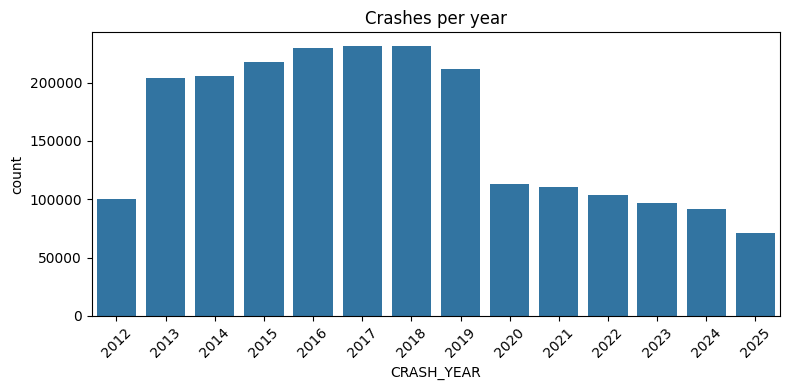

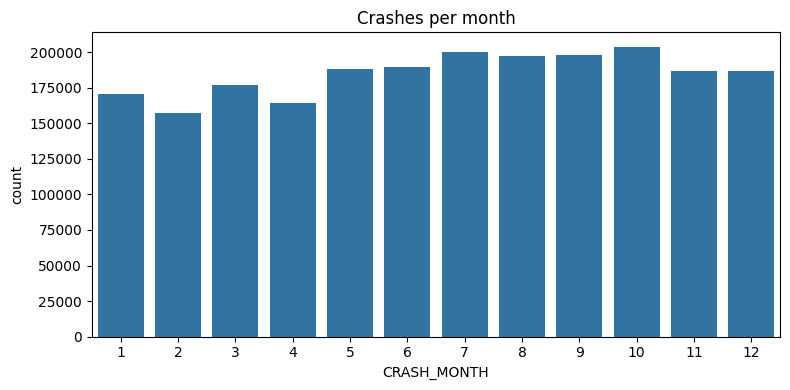

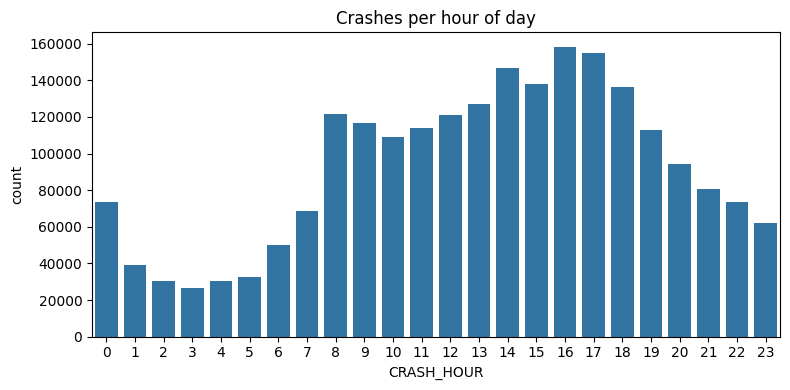


=== Crashes by BOROUGH (raw) ===
BOROUGH
UNKNOWN          679907
BROOKLYN         493110
QUEENS           412302
MANHATTAN        341031
BRONX            227861
STATEN ISLAND     64420
Name: count, dtype: Int64


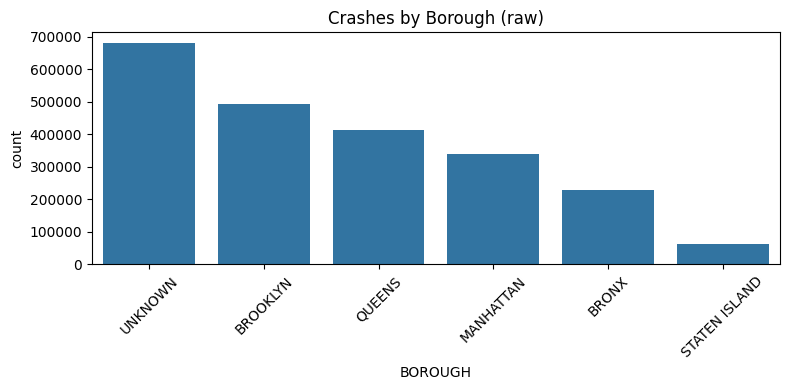


=== Injury / fatality summary ===
Rows with any injured:  537,308 (24.22%)
Rows with any killed:   3,371 (0.1519%)

Injured column stats:
count    2.218613e+06
mean     3.280716e-01
std      7.148684e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      4.300000e+01
Name: NUMBER OF PERSONS INJURED, dtype: float64

Killed column stats:
count    2.218600e+06
mean     1.585685e-03
std      4.206870e-02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      8.000000e+00
Name: NUMBER OF PERSONS KILLED, dtype: float64


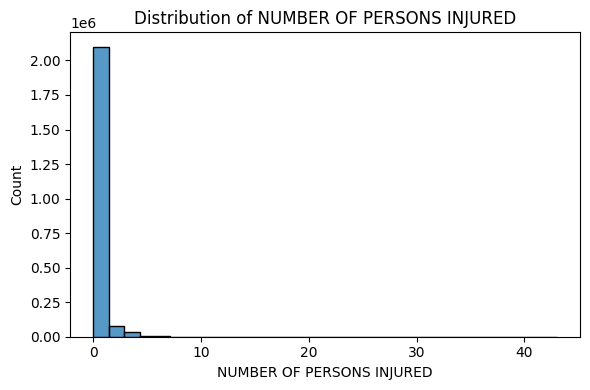


=== Coordinate coverage ===
LATITUDE non-null:  88.87%
LONGITUDE non-null: 88.87%


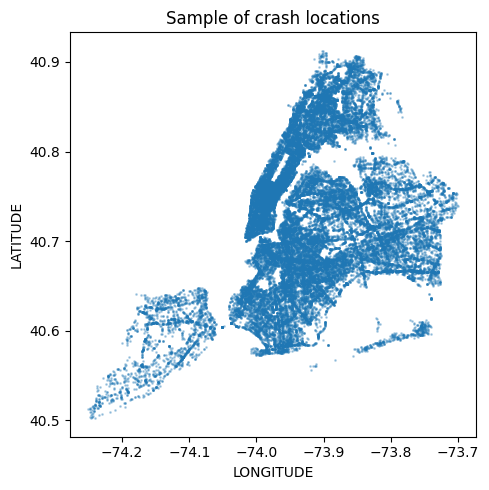


=== Duplicate rows summary (before cleaning) ===
Crashes exact duplicates: 0
Crashes duplicated COLLISION_ID: 0
Persons exact duplicates: 0
Persons duplicated UNIQUE_ID: 0


In [ ]:
# ============================================
# EDA – Crashes & Persons (before integration)
# ============================================

print("=== Crashes basic info ===")
print(df_crashes[["CRASH DATE", "CRASH TIME"]].head())
print("\nCrashes rows:", len(df_crashes))

print("\n=== Persons basic info ===")
print(df_persons.head())
print("\nPersons rows:", len(df_persons))

# 1) Crash year / month / hour distributions
print("\n=== Crash datetime distributions ===")
crash_dt = pd.to_datetime(df_crashes["CRASH DATE"] + " " + df_crashes["CRASH TIME"], errors="coerce")
df_crashes["CRASH_YEAR"]  = crash_dt.dt.year
df_crashes["CRASH_MONTH"] = crash_dt.dt.month
df_crashes["CRASH_HOUR"]  = crash_dt.dt.hour

print("Years range:", int(df_crashes["CRASH_YEAR"].min()), "→", int(df_crashes["CRASH_YEAR"].max()))
print("\nCrashes per year:")
print(df_crashes["CRASH_YEAR"].value_counts().sort_index())

plt.figure(figsize=(8,4))
sns.countplot(data=df_crashes, x="CRASH_YEAR",
              order=sorted(df_crashes["CRASH_YEAR"].dropna().unique()))
plt.title("Crashes per year")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
sns.countplot(data=df_crashes, x="CRASH_MONTH")
plt.title("Crashes per month")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
sns.countplot(data=df_crashes, x="CRASH_HOUR")
plt.title("Crashes per hour of day")
plt.tight_layout()
plt.show()

# 2) Borough distribution
if "BOROUGH" in df_crashes.columns:
    print("\n=== Crashes by BOROUGH (raw) ===")
    print(df_crashes["BOROUGH"].value_counts(dropna=False))

    plt.figure(figsize=(8,4))
    sns.countplot(data=df_crashes, x="BOROUGH",
                  order=df_crashes["BOROUGH"].value_counts().index)
    plt.title("Crashes by Borough (raw)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# 3) Injury / fatality rates
inj_col = "NUMBER OF PERSONS INJURED"
kill_col = "NUMBER OF PERSONS KILLED"

if inj_col in df_crashes.columns and kill_col in df_crashes.columns:
    total_rows = len(df_crashes)
    injured_any = (df_crashes[inj_col] > 0).sum()
    killed_any  = (df_crashes[kill_col] > 0).sum()
    print("\n=== Injury / fatality summary ===")
    print(f"Rows with any injured:  {injured_any:,} ({injured_any/total_rows:.2%})")
    print(f"Rows with any killed:   {killed_any:,} ({killed_any/total_rows:.4%})")

    print("\nInjured column stats:")
    print(df_crashes[inj_col].describe())
    print("\nKilled column stats:")
    print(df_crashes[kill_col].describe())

    plt.figure(figsize=(6,4))
    sns.histplot(df_crashes[inj_col], bins=30)
    plt.title("Distribution of NUMBER OF PERSONS INJURED")
    plt.tight_layout()
    plt.show()

# 4) Coordinate coverage / quality
if {"LATITUDE", "LONGITUDE"}.issubset(df_crashes.columns):
    lat_non_null = df_crashes["LATITUDE"].notna().mean() * 100
    lon_non_null = df_crashes["LONGITUDE"].notna().mean() * 100
    print("\n=== Coordinate coverage ===")
    print(f"LATITUDE non-null:  {lat_non_null:.2f}%")
    print(f"LONGITUDE non-null: {lon_non_null:.2f}%")

    # optional: quick small sample scatter (not full dataset to avoid lag)
    sample = df_crashes.sample(min(50_000, len(df_crashes)), random_state=42)
    plt.figure(figsize=(5,5))
    plt.scatter(sample["LONGITUDE"], sample["LATITUDE"], s=1, alpha=0.3)
    plt.title("Crash locations (raw crashes sample)")
    plt.xlabel("LONGITUDE")
    plt.ylabel("LATITUDE")
    plt.tight_layout()
    plt.show()

# 5) Duplicates summary (before cleaning)
print("\n=== Duplicate rows summary (before cleaning) ===")
print("Crashes exact duplicates:", df_crashes.duplicated().sum())
if "COLLISION_ID" in df_crashes.columns:
    print("Crashes duplicated COLLISION_ID:", df_crashes["COLLISION_ID"].duplicated().sum())

print("Persons exact duplicates:", df_persons.duplicated().sum())
if "UNIQUE_ID" in df_persons.columns:
    print("Persons duplicated UNIQUE_ID:", df_persons["UNIQUE_ID"].duplicated().sum())


In [ ]:
title("Crashes - Data Cleaning")
df_crashes=cleanData(df_crashes)

title("Persons - Data Cleaning")
df_persons=cleanData(df_persons)

Crashes - Data Cleaning
Before removing duplicates: (2218631, 42)
After removing  duplicates: (2218631, 42)

Persons - Data Cleaning
Before removing duplicates: (5813820, 27)
After removing  duplicates: (5813820, 27)



In [ ]:
# df_merged = pd.merge(df_crashes, df_persons, on="COLLISION_ID", how="inner")
# title("Merged - Data Overview")
# datasetOverview(df_merged)

In [ ]:
# df_merged=cleanData(df_merged)

In [ ]:
# Save cleaned DataFrames for Member 3
out_crashes = "clean_crashes.csv"
out_persons = "clean_persons.csv"

if "df_crashes" in globals() and "df_persons" in globals():
    df_crashes.to_csv(out_crashes, index=False)
    df_persons.to_csv(out_persons, index=False)
    print(f"Saved {out_crashes} ({df_crashes.shape[0]:,} rows, {df_crashes.shape[1]} cols)")
    print(f"Saved {out_persons} ({df_persons.shape[0]:,} rows, {df_persons.shape[1]} cols)")
else:
    missing = [n for n in ("df_crashes","df_persons") if n not in globals()]
    raise RuntimeError(f"Required DataFrame(s) not found in the notebook namespace: {missing}")

Saved clean_crashes.csv (2,218,631 rows, 42 cols)
Saved clean_persons.csv (5,813,820 rows, 27 cols)


Member 3 


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

clean_crashes = pd.read_csv('clean_crashes.csv')
clean_persons = pd.read_csv('clean_persons.csv')

In [26]:
# 2) Merge on COLLISION_ID (main integration key)
df_merged = pd.merge(clean_crashes, clean_persons, on="COLLISION_ID", how="left", validate= "1:m")
print("Merged shape:", df_merged.shape)
display(df_merged.head())

Merged shape: (6443821, 68)


,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,PED_ROLE,CONTRIBUTING_FACTOR_1,CONTRIBUTING_FACTOR_2,PERSON_SEX,crash_date_parsed_y,crash_time_parsed_y,person_datetime,person_year,person_month,person_hour
0,09/11/2021,2:39,UNKNOWN,NaN,NaN,NaN,NaN,WHITESTONE EXPRESSWAY,20 AVENUE,NaN,...,Driver,NaN,NaN,M,2021-09-11,02:39:00,2021-09-11 02:39:00,2021.0,9.0,2.0
1,09/11/2021,2:39,UNKNOWN,NaN,NaN,NaN,NaN,WHITESTONE EXPRESSWAY,20 AVENUE,NaN,...,Registrant,NaN,NaN,NaN,2021-09-11,02:39:00,2021-09-11 02:39:00,2021.0,9.0,2.0
2,09/11/2021,2:39,UNKNOWN,NaN,NaN,NaN,NaN,WHITESTONE EXPRESSWAY,20 AVENUE,NaN,...,Registrant,NaN,NaN,M,2021-09-11,02:39:00,2021-09-11 02:39:00,2021.0,9.0,2.0
3,09/11/2021,2:39,UNKNOWN,NaN,NaN,NaN,NaN,WHITESTONE EXPRESSWAY,20 AVENUE,NaN,...,Passenger,NaN,NaN,M,2021-09-11,02:39:00,2021-09-11 02:39:00,2021.0,9.0,2.0
4,03/26/2022,11:45,UNKNOWN,NaN,NaN,NaN,NaN,QUEENSBORO BRIDGE UPPER,NaN,NaN,...,Driver,NaN,NaN,F,2022-03-26,11:45:00,2022-03-26 11:45:00,2022.0,3.0,11.0


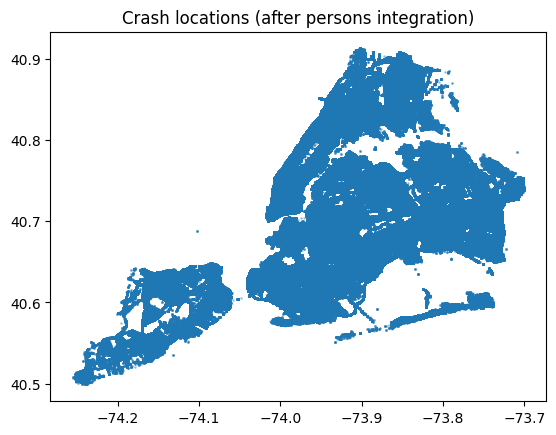

In [28]:
#extra scatter plot
plt.scatter(df_merged['LONGITUDE'], df_merged['LATITUDE'], s=1, alpha=0.3)
plt.title("Crash locations (after persons integration)")
plt.show()

In [29]:
# 3) Inspect nulls introduced by the join
nulls = df_merged.isnull().sum().sort_values(ascending=False)
display(nulls[nulls > 0].head(30))

# 4) Identify duplicated columns (_x / _y) created during merge
dup_pairs = {}
for col in df_merged.columns:
    if col.endswith('_x') and col[:-2] + '_y' in df_merged.columns:
        base = col[:-2]
        dup_pairs[base] = (base + '_x', base + '_y')
dup_pairs


VEHICLE TYPE CODE 5              6376072
CONTRIBUTING FACTOR VEHICLE 5    6374345
CONTRIBUTING_FACTOR_2            6343251
CONTRIBUTING_FACTOR_1            6343119
PED_ACTION                       6341841
PED_LOCATION                     6341740
VEHICLE TYPE CODE 4              6238291
CONTRIBUTING FACTOR VEHICLE 4    6232260
coord_issue_reason               5784518
VEHICLE TYPE CODE 3              5720336
CONTRIBUTING FACTOR VEHICLE 3    5698746
PERSON_ID                        5459347
OFF STREET NAME                  5224182
SAFETY_EQUIPMENT                 3657046
EJECTION                         3454677
POSITION_IN_VEHICLE              3454220
EMOTIONAL_STATUS                 3357937
BODILY_INJURY                    3357894
COMPLAINT                        3357887
CROSS STREET NAME                2908913
ZIP CODE                         2305770
ON STREET NAME                   1330293
PERSON_SEX                       1272925
VEHICLE TYPE CODE 2               880157
VEHICLE_ID      

{'crash_date_parsed': ('crash_date_parsed_x', 'crash_date_parsed_y'),
 'crash_time_parsed': ('crash_time_parsed_x', 'crash_time_parsed_y')}

In [30]:
# 5) Combine duplicated columns safely
for base, (cx, cy) in dup_pairs.items():
    df_merged[base] = df_merged[cx].combine_first(df_merged[cy])
    df_merged.drop([cx, cy], axis=1, inplace=True)

# remove duplicated column names (if any)
df_merged = df_merged.loc[:, ~df_merged.columns.duplicated()]


In [31]:
# 6) Fix types
if 'CRASH_DATE' in df_merged.columns:
    df_merged['CRASH_DATE'] = pd.to_datetime(df_merged['CRASH_DATE'], errors='coerce')

if 'CRASH_TIME' in df_merged.columns:
    df_merged['CRASH_TIME'] = pd.to_datetime(df_merged['CRASH_TIME'], format='%H:%M', errors='coerce').dt.time

for c in ['BOROUGH', 'PERSON_TYPE', 'PERSON_INJURY', 'VEHICLE_TYPE_CODE_1']:
    if c in df_merged.columns:
        df_merged[c] = df_merged[c].astype('category')

# 7) Remove duplicate rows
dup_rows = df_merged.duplicated().sum()
print("Exact duplicate rows:", dup_rows)
if dup_rows:
    df_merged.drop_duplicates(inplace=True)


Exact duplicate rows: 0


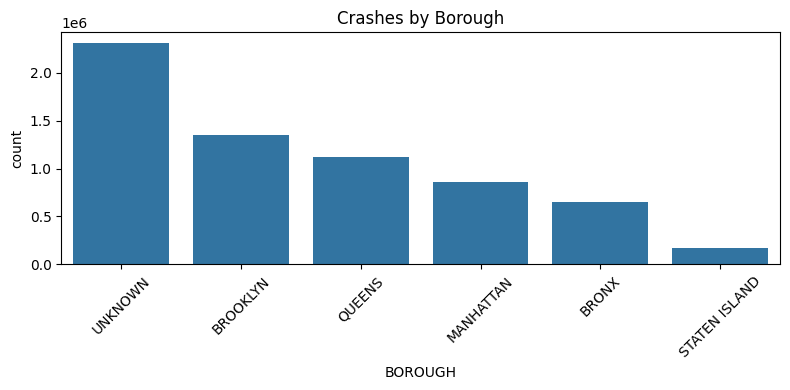

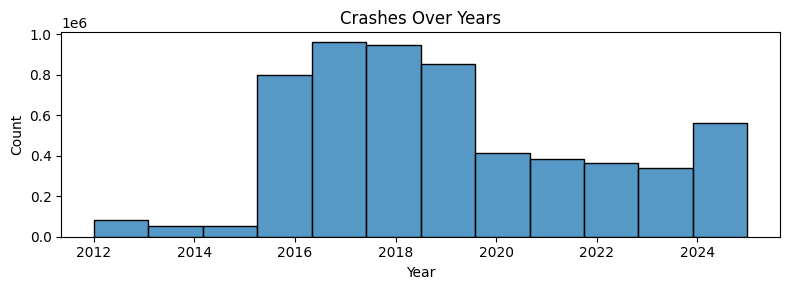

In [32]:
# 8) Validate and visualize
plt.figure(figsize=(8,4))
if 'BOROUGH' in df_merged.columns:
    sns.countplot(data=df_merged, x='BOROUGH', order=df_merged['BOROUGH'].value_counts().index)
    plt.title('Crashes by Borough')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plt.figure(figsize=(8,3))
if 'CRASH_DATE' in df_merged.columns:
    sns.histplot(df_merged['CRASH_DATE'].dt.year.dropna(), bins=12)
    plt.title('Crashes Over Years')
    plt.xlabel('Year')
    plt.tight_layout()
    plt.show()


In [33]:
df_merged.to_csv("integrated_collisions.csv", index=False)
print("Saved integrated dataset → integrated_collisions.csv")


Saved integrated dataset → integrated_collisions.csv


In [34]:
#Member 4

In [35]:
# Small artifact for the dashboard (fast to load)
dash_keep = [
    "COLLISION_ID","crash_datetime","CRASH_YEAR","CRASH_MONTH","CRASH_HOUR","CRASH_WEEKDAY",
    "BOROUGH","ZIP CODE","LATITUDE","LONGITUDE",
    "NUMBER OF PERSONS INJURED","NUMBER OF PERSONS KILLED",
    "CONTRIBUTING FACTOR VEHICLE 1","VEHICLE TYPE CODE 1",
    "persons_count","persons_injured","persons_killed","PEDESTRIAN","BICYCLIST","MOTORIST","median_age"
]
dash_keep = [c for c in dash_keep if c in df_merged.columns]
df_dash = df_merged[dash_keep].copy()
df_dash.to_csv("D:\\NYC-motor-vehicle-collisions\\NYC-motor-vehicle-collisions\\data\\dashboard_ready.csv", index=False)
print("✅ Saved lightweight dashboard extract → data/dashboard_ready.csv", df_dash.shape)


✅ Saved lightweight dashboard extract → data/dashboard_ready.csv (6443821, 13)


In [36]:
# ============================================
# E) Post-join audit & sanity checks
# ============================================

print("=== Basic shapes ===")
print("df_crashes_small:", df_crashes_small.shape)
print("persons_agg:     ", persons_agg.shape)
print("df_merged:       ", df_merged.shape)
print("df_dash:         ", df_dash.shape)

# 1) Are all crashes still there?
total_crashes   = df_crashes_small["COLLISION_ID"].nunique()
merged_crashes  = df_merged["COLLISION_ID"].nunique()
dash_crashes    = df_dash["COLLISION_ID"].nunique()
print("\n=== Crash ID coverage ===")
print(f"Crashes in cleaned crashes table: {total_crashes:,}")
print(f"Crashes in merged table:         {merged_crashes:,}")
print(f"Crashes in dashboard extract:    {dash_crashes:,}")

# 2) How many crashes have *no* persons info?
if "persons_count" in df_merged.columns:
    zero_persons = (df_merged["persons_count"] == 0).mean() * 100
    print(f"\nCrashes with no persons rows (persons_count=0): {zero_persons:.2f}%")

# 3) Quick null overview of key columns
key_cols = [
    "BOROUGH", "ZIP CODE", "LATITUDE", "LONGITUDE",
    "NUMBER OF PERSONS INJURED", "NUMBER OF PERSONS KILLED",
    "persons_count", "persons_injured", "persons_killed", "median_age"
]
key_cols = [c for c in key_cols if c in df_merged.columns]

print("\n=== Null rates for key columns ===")
null_rates = df_merged[key_cols].isna().mean().sort_values(ascending=False) * 100
print(null_rates.round(2))

# 4) Basic distributions for report text
print("\n=== Crashes by BOROUGH ===")
if "BOROUGH" in df_merged.columns:
    print(df_merged["BOROUGH"].value_counts(dropna=False).head(10))

print("\n=== Injury distribution (NUMBER OF PERSONS INJURED) ===")
if "NUMBER OF PERSONS INJURED" in df_merged.columns:
    print(df_merged["NUMBER OF PERSONS INJURED"].describe())

print("\n=== Persons per crash (persons_count) ===")
if "persons_count" in df_merged.columns:
    print(df_merged["persons_count"].describe())


=== Basic shapes ===
df_crashes_small: (2218631, 16)
persons_agg:      (1588630, 8)
df_merged:        (6443821, 66)
df_dash:          (6443821, 13)

=== Crash ID coverage ===
Crashes in cleaned crashes table: 2,218,631
Crashes in merged table:         2,218,631
Crashes in dashboard extract:    2,218,631

=== Null rates for key columns ===
ZIP CODE                     35.78
LATITUDE                     10.23
LONGITUDE                    10.23
NUMBER OF PERSONS KILLED      0.00
NUMBER OF PERSONS INJURED     0.00
BOROUGH                       0.00
dtype: float64

=== Crashes by BOROUGH ===
BOROUGH
UNKNOWN          2304724
BROOKLYN         1347458
QUEENS           1116338
MANHATTAN         857563
BRONX             650333
STATEN ISLAND     167405
Name: count, dtype: int64

=== Injury distribution (NUMBER OF PERSONS INJURED) ===
count    6.443779e+06
mean     4.726320e-01
std      1.011432e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      4.

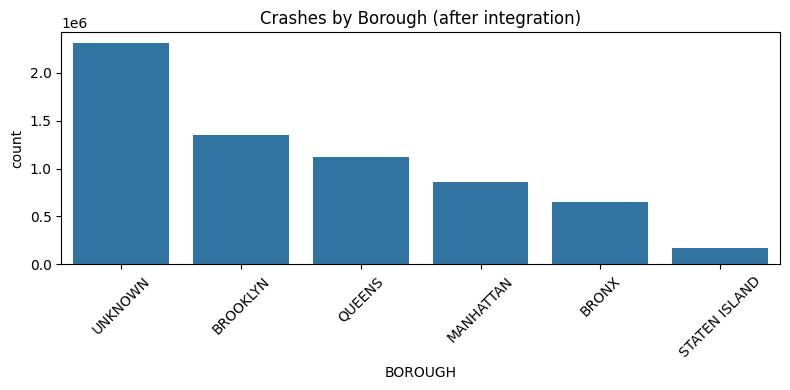

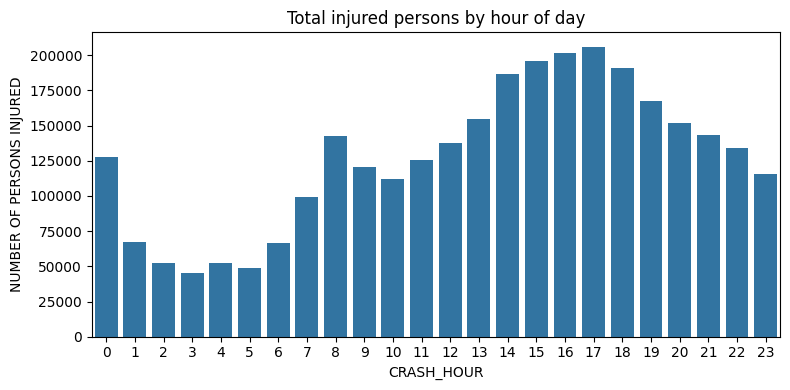

In [37]:
# ============================================
# F) Simple post-join visual checks
# ============================================

import matplotlib.pyplot as plt
import seaborn as sns

# 1) Crashes by BOROUGH
if "BOROUGH" in df_merged.columns:
    plt.figure(figsize=(8,4))
    sns.countplot(data=df_merged, x="BOROUGH",
                  order=df_merged["BOROUGH"].value_counts().index)
    plt.title("Crashes by Borough (after integration)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# 2) Persons per crash (histogram)
if "persons_count" in df_merged.columns:
    plt.figure(figsize=(6,4))
    sns.histplot(df_merged["persons_count"], bins=20)
    plt.title("Distribution of persons per crash")
    plt.xlabel("persons_count")
    plt.tight_layout()
    plt.show()

# 3) Injured persons by hour of day
if {"CRASH_HOUR", "NUMBER OF PERSONS INJURED"}.issubset(df_merged.columns):
    hourly = (df_merged
              .groupby("CRASH_HOUR", as_index=False)["NUMBER OF PERSONS INJURED"]
              .sum())
    plt.figure(figsize=(8,4))
    sns.barplot(data=hourly, x="CRASH_HOUR", y="NUMBER OF PERSONS INJURED")
    plt.title("Total injured persons by hour of day")
    plt.tight_layout()
    plt.show()
